# Sentiment Analysis on Florida--Scrap Notebook -- only run once both datasets are good 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.style as style
import seaborn as sns
from datetime import datetime, timedelta
from tqdm import tqdm
import pytz

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# Link to this Sentiment Analyzer: https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f

## All function used in notebook

In [2]:
def set_index_datetime_in_timezone(data, timezone):
    '''
    Takes a list of dataframes formatted [dataframe, timezone]
    Sets index of each dataframe to datetime and sorts the dataframe
    
    See pytz.timezone() documentation for all acceptable timezones.
    For the US, use the following:
    
    US/Central
    US/Eastern
    US/Mountain
    US/Pacific
    '''
    
    timezone_map = {'eastern': -4,
                    'central': -5,
                    'mountain': -6,
                    'pacific': -7}
    
    # Create datetime in local timezone
    data.index = pd.to_datetime(data.index, errors='coerce')
    data.sort_index(inplace=True)
    data.index = data.index.tz_convert(timezone)




In [3]:
# provided from link 
def sentiment_analyzer_scores(sentence):    
    score = analyser.polarity_scores(sentence)
    return score

In [4]:
# Analyze our city data
def vader_analyzer(data):
    '''
    Takes pandas dataframe of info scraped from twitter and performs sentiment
    analysis. Creates 5 new columns to be used in sentiment analysis:
    'neg_score' - negative score
    'neu_score' - neutral score
    'pos_score' - positive score
    'compound_score' - (score < -0.05 = negative
                        score between -0.05 and 0.05 = neutral
                        score > 0.05 = positive)
    '''
    data['sentiment_analysis'] = data.progress_apply(lambda x: sentiment_analyzer_scores(x['text']), axis=1)
    data['neg_score'] = data['sentiment_analysis'].progress_apply(lambda x: x['neg'])
    data['neu_score'] = data['sentiment_analysis'].progress_apply(lambda x: x['neu'])
    data['pos_score'] = data['sentiment_analysis'].progress_apply(lambda x: x['pos'])
    data['compound_score'] = data['sentiment_analysis'].progress_apply(lambda x: x['compound'])

In [5]:
# Converting date to a datetime object in local time
def create_time_cols(data, timezone):
    
    timezone_map = {'eastern': -4,
                    'central': -5,
                    'mountain': -6,
                    'pacific': -7}
    
    # Creating relevant columns for plotting xticks
    data['month_day_hour'] = data.index.strftime(date_format='%m%d%H')


In [6]:
def plot_state_sentiment(data, timezone, covid_only=False, is_reopen=False):
#     # Creating this variable for x tick marks
    hour_group = data.resample('h').mean()['compound_score']
    days = data.resample('D').mean().index.strftime('%m-%d')
    timezone_map = {'eastern': -4,
                'central': -5,
                'mountain': -6,
                'pacific': -7}
    
    # Offset to ensure that the 'date shutdown announced' line lands on the right gridline
    axis_offset_map = {'eastern': '04', 
                           'central': '05',
                           'mountain': '06',
                           'pacific': '07'}
    
    # Create sentiment plot
    plt.figure(figsize=(32, 6))
    
    sns.lineplot(data=data,
                 x='month_day_hour',
                 y='compound_score', 
                 linewidth=2.5, 
                 color='blue')
    
    plt.axhspan(-.05, .05, color='gray', alpha=0.3)
    plt.axhspan(.05, np.percentile(data['compound_score'], 90), color='green', alpha=0.3)
    plt.axhspan(-.05, np.percentile(data['compound_score'], 10), color='red', alpha=0.3)
    
    
    plt.xticks(range(-(24 + timezone_map[timezone]), # Need to offset the xticks to account for timezone shift upon scraping 
                     len(hour_group), 
                     24),
               days.unique())
    
    # Sorry this isn't human readable :( it returns the date in the proper format to be plotted
    plt.axvline(str(timeline_dict[data['state'].reset_index().loc[0, 'state']] [is_reopen])[4:] + '00') 
    
    plt.legend(['_', 'Date shutdown was announced'])
    
    if covid_only:
        plt.title(f'{data["state"].reset_index().loc[0, "state"]} Sentiment Over Time In Tweets With Covid-Specific Terms')
    else:
        plt.title(f'{data["state"].reset_index().loc[0, "state"]} Sentiment Over Time')
    plt.xlabel('Date')
    plt.ylabel('Compound Score')
    plt.show();

In [24]:
def analyze_and_plot_sentiment(data, timezone, covid_only=False, is_reopen=False):
    vader_analyzer(data)
    create_time_cols(data, timezone)
    plot_state_sentiment(data, timezone, covid_only, is_reopen)

In [8]:
tqdm.pandas() # Allows us to see progress bars on pandas.apply methods

/Users/haleytaft/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [9]:
style.use('fivethirtyeight')

## Reading in Shutdown Data

In [10]:
# Reading in state data

fl_shutdown_df = pd.read_csv('./data/shutdown_data/FL_full.csv', low_memory=False, index_col='date')

In [11]:
fl_shutdown_df.head(1)

,username,to,text,retweets,favorites,replies,id,permalink,author_id,formatted_date,...,geo,urls,city,query,date_range,state,month,day,datetime,month_day
date,,,,,,,,,,,,,,,,,,,,,
2020-04-07 23:59:45+00:00,Venom_PT,NaN,BLACK PEOPLE WAKE UP!!! in my Mookie voice fro...,0,0,0,1247675460638605314,https://twitter.com/Venom_PT/status/1247675460...,36584184,Tue Apr 07 23:59:45 +0000 2020,...,NaN,https://www.instagram.com/p/B-su-E6pEI7AWoUKVP...,miami,get OR one OR time OR people OR day OR know OR...,"('2020-03-25', '2020-04-08')",FL,4,7,2020-04-07 23:59:45+00:00,407.0


## Reading in Reopening Data

In [12]:
fl_reopening_df = pd.read_csv('./data/reopening_data/FL_full.csv', low_memory=False, index_col='date')
fl_reopening_df.head(1)

,username,to,text,retweets,favorites,replies,id,permalink,author_id,formatted_date,...,geo,urls,city,query,date_range,state,month,day,datetime,month_day
date,,,,,,,,,,,,,,,,,,,,,
2020-05-05 23:59:50+00:00,NeverSweatHoes,NaN,No person is your friend who demands your sile...,0,1,0,1257822343180795904,https://twitter.com/NeverSweatHoes/status/1257...,1028834407954767873,Tue May 05 23:59:50 +0000 2020,...,NaN,NaN,miami,get OR one OR time OR people OR day OR know OR...,"('2020-04-22', '2020-05-06')",FL,5,5,2020-05-05 23:59:50+00:00,505


In [25]:
df_list = [[fl_shutdown_df, 'US/Eastern'], 
           [fl_reopening_df, 'US/Eastern']]

for df in df_list:
    set_index_datetime_in_timezone(df[0], df[1])

In [26]:
fl_covid_terms = ['pandemic', 'coronavirus', 'news', 'health', 'covid', '19', 'quarantine', 'governor', 'capitol', 'tallahassee', 'desantis', 'virus']

In [27]:
fl_shutdown_df_covid = fl_shutdown_df.copy()[fl_shutdown_df['text'].str.contains('|'.join(fl_covid_terms))]
fl_reopening_df_covid = fl_reopening_df.copy()[fl_reopening_df['text'].str.contains('|'.join(fl_covid_terms))]

In [28]:
timeline_dict = {
    'FL': [20200401, 20200429],
    'TX': [20200331, 20200518],
    'NJ': [20200316, 20200609],
    'NY': [20200322, 20200613],
    'IL': [20200320, 20200529],
    'GA': [20200402, 20200601],
    'OH': [20200322, 20200526],
    'MI': [20200323, 20200608]
}

In [29]:
covid_term_data = [[fl_shutdown_df_covid, 'eastern', False], 
                   [fl_reopening_df_covid, 'eastern', True]]

In [30]:
# Initializing Vader model 
analyser = SentimentIntensityAnalyzer()

100%|██████████| 16106/16106 [00:00<00:00, 302692.78it/s]
/Users/haleytaft/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fe97fea3890> has a label of '_' which cannot be automatically added to the legend.


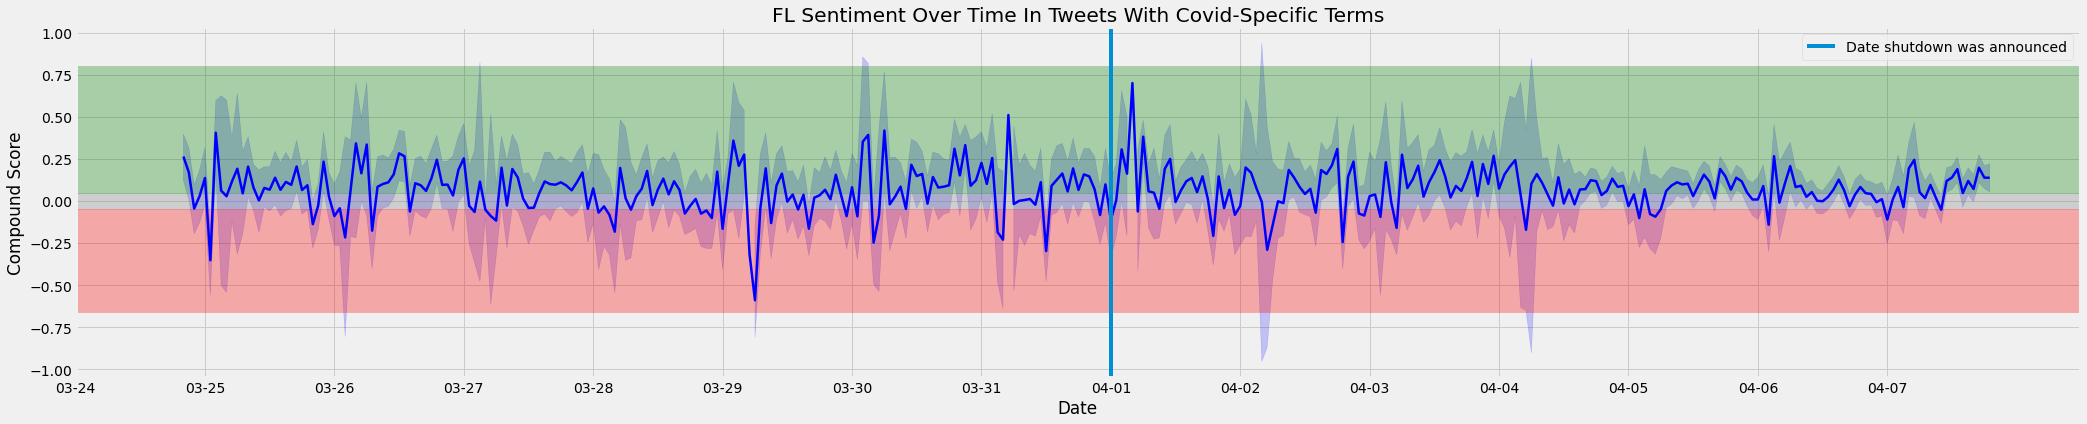

100%|██████████| 9313/9313 [00:00<00:00, 304975.39it/s]
/Users/haleytaft/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fe9768b2910> has a label of '_' which cannot be automatically added to the legend.


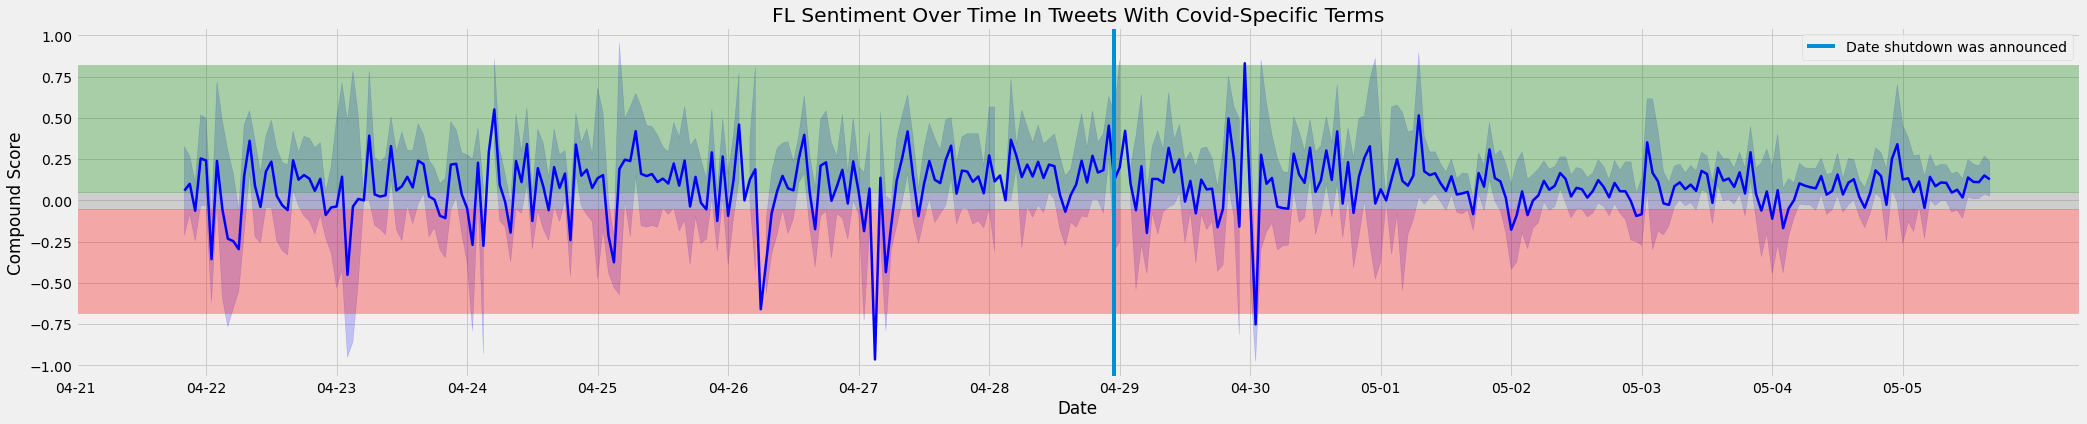

In [31]:
for i in range(len(covid_term_data)):
    analyze_and_plot_sentiment(covid_term_data[i][0], covid_term_data[i][1], covid_only=True, is_reopen=covid_term_data[i][2])

In [32]:
general_terms_data = [[fl_shutdown_df, 'eastern'],
                      [fl_reopening_df, 'eastern']]

100%|██████████| 81093/81093 [00:00<00:00, 540198.07it/s]
/Users/haleytaft/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fe97e5c9c90> has a label of '_' which cannot be automatically added to the legend.


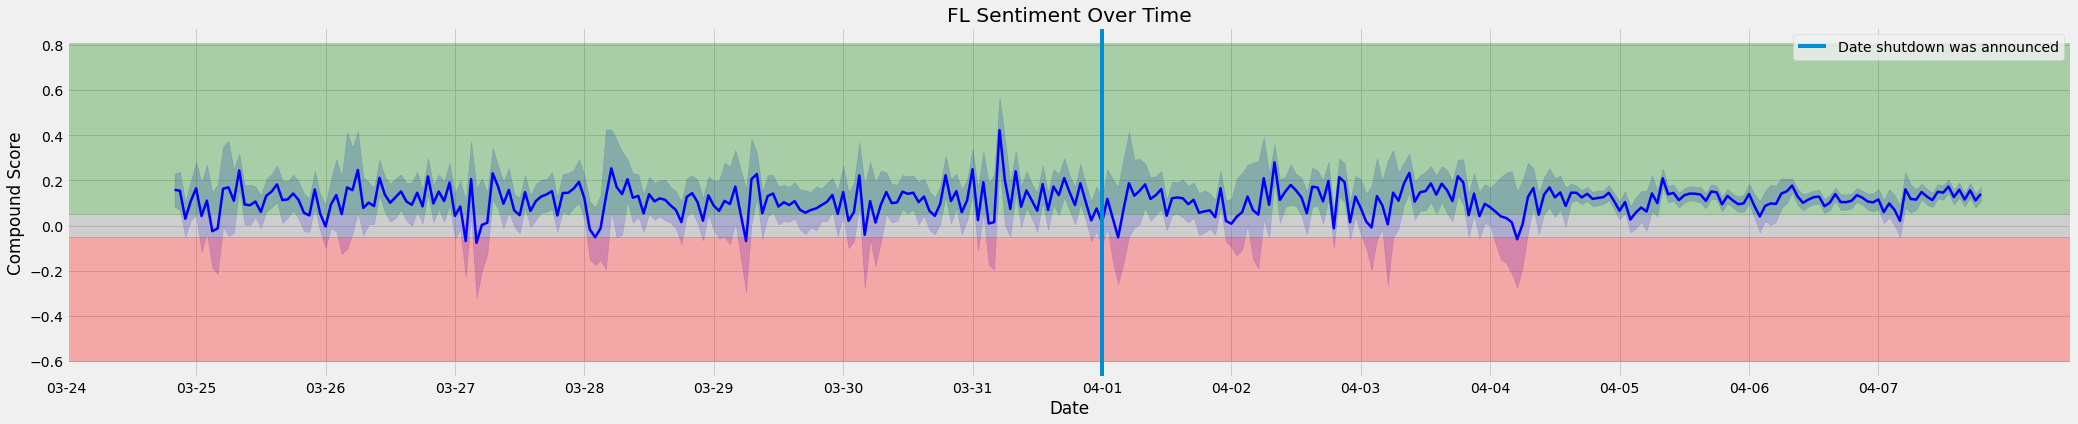

100%|██████████| 69410/69410 [00:00<00:00, 542515.13it/s]
/Users/haleytaft/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fe980607b10> has a label of '_' which cannot be automatically added to the legend.


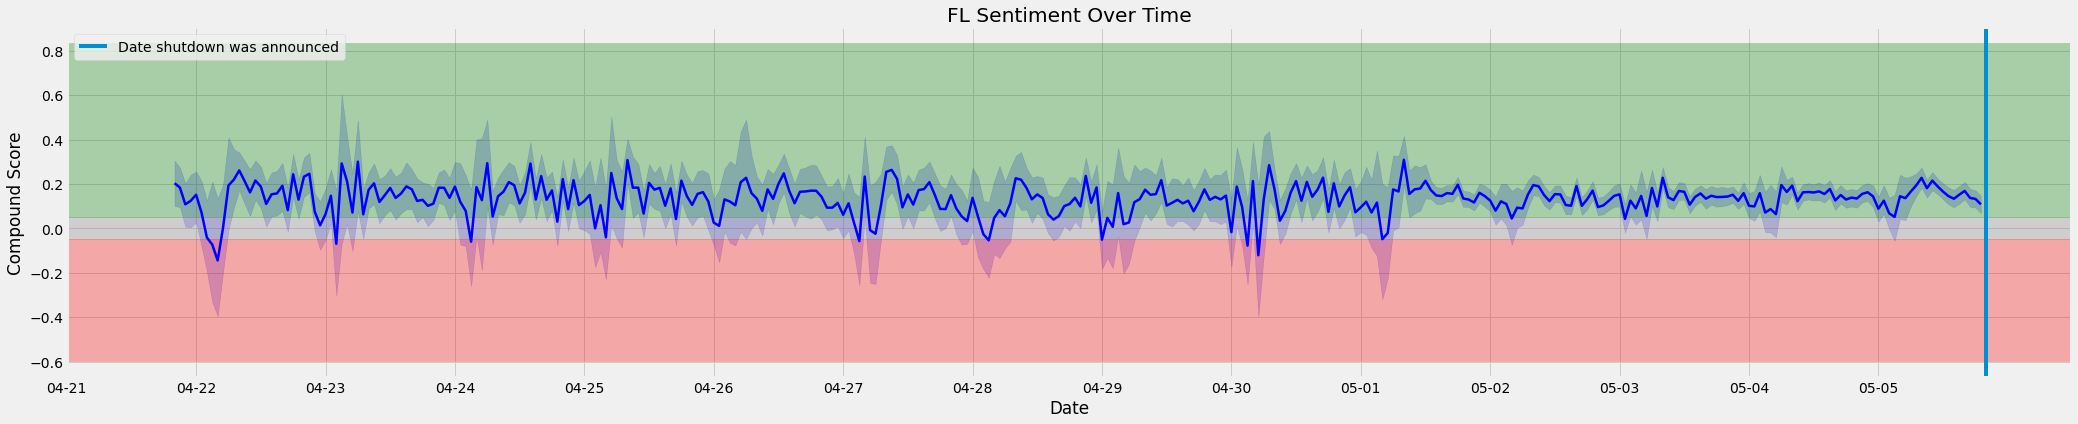

In [33]:
for i in range(len(general_terms_data)):
    analyze_and_plot_sentiment(general_terms_data[i][0], general_terms_data[i][1], covid_only=False)